<a href="https://colab.research.google.com/github/Nasif1998/Heart-Disease-Analysis/blob/main/Copy_of_Heart_disease_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Structured Data Classification (Heart Disease)

This notebook builds an end-to-end machine learning and deep learning pipeline for predicting heart disease using structured clinical data.

We compare:
- Classical machine learning models (Logistic Regression, Random Forest)
- A neural network (Multi-Layer Perceptron, PyTorch)

The goal is to evaluate these approaches under a clean, leakage-free experimental

## Goal

Given a set of patient-level clinical attributes (e.g., age, sex, cholesterol, blood pressure),
the task is to predict whether a patient has heart disease (binary classification).

We use:
- Past patient measurements as input features
- A binary target indicating the presence of heart disease

The focus is on correct preprocessing, fair evaluation, and model comparison.


In [ ]:
!pip install xgboost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve,
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, average_precision_score
)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.2

## Methodology Overview

This notebook follows a strict experimental protocol:

1. Data preprocessing (imputation, scaling, encoding)
2. Stratified train/validation/test split
3. Model training and hyperparameter tuning
4. Validation-based model and threshold selection
5. Final evaluation on a held-out test set

This ensures a fair and unbiased comparison between models.


# **Functions**

In [ ]:
def to_dense(x):
    """Converting sparse matrices to dense arrays when needed.

    Why this exists:
    - Some preprocessing steps (e.g., OneHotEncoder) can output sparse matrices.
    - PyTorch tensors need dense numpy arrays, so we convert *only if* the object is sparse.

    Parameters
    ----------
    x : array-like or sparse matrix
        The feature matrix produced by scikit-learn preprocessors.

    Returns
    -------
    array-like
        Dense numpy array if `x` is sparse, otherwise returns `x` unchanged.
    """
    # Many sklearn transformers return SciPy sparse matrices which have .toarray().
    # If x does not have .toarray(), it's already dense (numpy array / pandas array).
    return x.toarray() if hasattr(x, 'toarray') else x

In [ ]:
def eval_metrics(y_true, y_prob, thr):
    """Computing common binary-classification metrics at a chosen threshold.

    Why this exists:
    - ROC-AUC uses probabilities and is threshold-free (good for model comparison).
    - Accuracy/Precision/Recall/F1 require a hard decision -> we need a threshold.
    - In this notebook, we select the threshold on the VALIDATION set (to avoid test leakage).

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Ground-truth labels (0/1).
    y_prob : array-like of shape (n_samples,)
        Predicted probabilities for the positive class (class 1).
    thr : float
        Decision threshold. Predict 1 if probability >= thr else 0.

    Returns
    -------
    dict
        Dictionary containing accuracy, precision, recall, F1, and ROC-AUC.
    """
    # Converting probabilities into class predictions based on the chosen threshold.
    y_pred = (y_prob >= thr).astype(int)
    # zero_division=0 prevents warnings when a metric is undefined (example: no predicted positives).
    return {
        'acc': accuracy_score(y_true, y_pred),
        'prec': precision_score(y_true, y_pred, zero_division=0),
        'rec': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        # ROC-AUC evaluates ranking quality of probabilities (independent of threshold).
        'auc': roc_auc_score(y_true, y_prob)
    }

In [ ]:
def print_metrics(name, m):
    """Printing a metric dictionary.

    Why this exists:
    - Keeps the notebook outputs consistent and easy to compare across models.
    - Avoids repeating the same print-formatting code many times.
    """
    print(f'\n[{name}]')
    print(f'Accuracy : {m["acc"]:.3f}')
    print(f'Precision: {m["prec"]:.3f}')
    print(f'Recall   : {m["rec"]:.3f}')
    print(f'F1       : {m["f1"]:.3f}')
    print(f'ROC-AUC  : {m["auc"]:.3f}')

In [ ]:
def plot_threshold_sweep(y_true, y_prob, title, save_path=None):
    """Sweeping thresholds and visualizing Precision/Recall/F1 to pick a sensible decision rule.

    Why this exists:
    - Many datasets are imbalanced or have asymmetric costs (false negatives vs false positives).
    - Using the default 0.50 threshold is often suboptimal.
    - We choose the threshold ONLY on the VALIDATION set to keep the TEST set unbiased.

    Strategy used here:
    - Evaluating a grid of thresholds from 0.05 to 0.95
    - Selecting the threshold that maximizes validation F1 (balance of precision+recall)

    Returns
    -------
    best_t : float
        Threshold that maximizes F1 over the swept thresholds.
    """
    thresholds = np.linspace(0.05, 0.95, 19)
    f1s, precs, recs = [], [], []

    for t in thresholds:
      # Converting probabilities -> hard predictions at threshold t
        y_pred = (y_prob >= t).astype(int)

        # Storing metrics to plot the trade-offs
        f1s.append(f1_score(y_true, y_pred, zero_division=0))
        precs.append(precision_score(y_true, y_pred, zero_division=0))
        recs.append(recall_score(y_true, y_pred, zero_division=0))

    # Choosing threshold with best F1 (validation)
    best_idx = int(np.argmax(f1s))
    best_t = float(thresholds[best_idx])

    # --------- Ploting the sweep curves ---------
    plt.figure()
    plt.plot(thresholds, f1s, marker='o', label='F1')
    plt.plot(thresholds, precs, marker='o', label='Precision')
    plt.plot(thresholds, recs, marker='o', label='Recall')
    plt.axvline(best_t, linestyle='--', label=f'Best thr={best_t:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend()
    plt.tight_layout()

    if save_path is not None:
      # Saving figures helps for the final report (reproducible artifacts).
        plt.savefig(save_path, dpi=200, bbox_inches='tight')

    plt.show()

    print(f'Chosen threshold (max F1 on VAL): {best_t:.2f}')
    return best_t


In [ ]:
def plot_roc_pr(y_true, y_prob, title_prefix, save_roc_path=None, save_pr_path=None):
    """Ploting ROC and Precision-Recall curves for a probability classifier.

    Why this exists:
    - ROC curve shows TPR vs FPR across thresholds; AUC is a global ranking metric.
    - PR curve is often more informative under class imbalance (focuses on positive class).
    - These plots are standard in ML reports and help justify model choice.

    Notes
    -----
    - We passed y_prob (probabilities), not hard predictions.
    - Curves are usually plotted on VALIDATION during model selection and on TEST only once at the end.
    """
     # --------- ROC ---------
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)

    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--') # random baseline
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title_prefix} ROC (AUC={auc:.3f})')
    plt.tight_layout()

    if save_roc_path is not None:
        plt.savefig(save_roc_path, dpi=200, bbox_inches='tight')

    plt.show()

    # --------- Precision-Recall ---------
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)

    plt.figure()
    plt.plot(rec, prec)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{title_prefix} PR (AP={ap:.3f})')
    plt.tight_layout()

    if save_pr_path is not None:
        plt.savefig(save_pr_path, dpi=200, bbox_inches='tight')

    plt.show()


In [ ]:
def plot_cm(y_true, y_prob, thr, title, save_path=None):
    """Ploting a confusion matrix at a given threshold.

    Why this exists:
    - Confusion matrix shows the *types* of mistakes (FP vs FN), not just one number.
    - In medical tasks, False Negatives can be especially costly -> this plot makes it visible.

    Parameters
    ----------
    thr : float
        Threshold chosen on VALIDATION (and then reused on TEST without re-tuning).
    """

    # Converting probabilities into predicted classes at the chosen threshold
    y_pred = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'{title} (thr={thr:.2f})')
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=200, bbox_inches='tight')

    plt.show()


In [ ]:
def make_preprocess(cols):
    """Building a robust preprocessing block for tabular heart-disease data.

    Why this exists:
    - Mixed feature types: some columns are categorical (need one-hot), others numeric (need scaling).
    - We must handle missing values safely and consistently.
    - Putting preprocessing inside a Pipeline ensures:
        (1) no data leakage during cross-validation
        (2) the exact same transforms are applied to train/val/test

    Parameters
    ----------
    cols : list-like
        List of feature column names used for training.

    Returns
    -------
    ColumnTransformer
        A transformer that applies numeric + categorical preprocessing in parallel.
    """
    # Spliting features into categorical vs numerical so we can apply correct preprocessing:
    # Categorical columns based on dataset schema (only keep those that exist in `cols`)
    cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
    cat_cols = [c for c in cat_cols if c in cols]

    # Everything else is treated as numeric
    num_cols = [c for c in cols if c not in cat_cols]

    # Numeric preprocessing:
    # - median imputation is robust to outliers
    # - standardization helps models like Logistic Regression
    num_tf = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Categorical preprocessing:
    # - most_frequent imputation fills missing categories
    # - one-hot encoding converts categories into indicator features
    # - handle_unknown='ignore' prevents errors when val/test has unseen categories
    cat_tf = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # ColumnTransformer applies each transformer to its specified columns.
    # IMPORTANT: We return the transformer (not fit it here). Fitting happens inside Pipelines on TRAIN only.
    return ColumnTransformer([
        ('num', num_tf, num_cols),
        ('cat', cat_tf, cat_cols)
    ])


# **EDA**

In [ ]:
def show_target_counts(y_train, y_val, y_test, save_path=None):
    """Printing + plotting the target distribution across Train/Val/Test splits.

    Why this exists:
    - We stratify splits to preserve class balance, but we still verify it.
    - If distributions differ too much, validation/test results may be misleading.
    """
    counts = pd.DataFrame({
        'train': y_train.value_counts(),
        'val': y_val.value_counts(),
        'test': y_test.value_counts()
    }).fillna(0).astype(int)

    print(f'\nTarget counts across splits:\n{counts}\n')

    plt.figure()
    counts.T.plot(kind='bar')
    plt.title('Figure: Target distribution across Train/Val/Test')
    plt.xlabel('Split')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=200, bbox_inches='tight')

    plt.show()


In [ ]:
def eda_plots(df):
    """
    Purpose:
    This function performs basic Exploratory Data Analysis (EDA) by generating
    visualizations that help understand the structure and quality of the dataset.

    Why this function is needed:
    Before training any machine learning model, it is essential to explore the data
    in order to:
    - Check for class imbalance in the target variable
    - Identify missing values that require preprocessing
    - Examine how numerical features behave across target classes
    - Detect correlations between features that may affect model stability
    """

    # 1. Target class distribution
    # =====================================================
    # Why:
    # In a classification problem, class imbalance can bias the model.
    # Visualizing the target distribution helps assess whether special
    # handling stratification or class weights is required.
    plt.figure()
    df['target'].value_counts().plot(kind='bar')
    plt.title('Figure 1: Class Distribution (target)')
    plt.xlabel('Target (0 = No disease, 1 = Disease)')
    plt.ylabel('Count')
    plt.show()


    # 2. Missing values visualization
    # =====================================================
    # Why:
    # Missing values can negatively impact model training.
    # A heatmap provides a quick overview of which features contain
    # missing data and whether the pattern is systematic.
    plt.figure(figsize=(8, 4))
    sns.heatmap(df.isna(), cbar=False)
    plt.title('Figure 2: Missing Values Map')
    plt.show()

    # 3. Feature distributions by target class
    # =====================================================
    # Why:
    # Boxplots allow comparison of numerical feature distributions
    # across target classes, highlighting differences in medians,
    # spread, and the presence of outliers.
    box_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    for col in box_cols:
        if col in df.columns:
            plt.figure()
            sns.boxplot(x='target', y=col, data=df)
            plt.title(f'Figure 3: {col} by Target')
            plt.show()

    # 4. Correlation heatmap
    # =====================================================
    # Why:
    # Highly correlated features can introduce multicollinearity,
    # which may affect the interpretability and stability of
    # linear models such as Logistic Regression.
    num_df = df.select_dtypes(include=[np.number])
    plt.figure(figsize=(10, 8))
    sns.heatmap(num_df.corr(), cmap='coolwarm', center=0)
    plt.title('Figure 4: Correlation Heatmap (numeric features)')
    plt.show()


In [ ]:

def plot_roc_compare(y_true, prob_ml, prob_dl, label_ml="ML", label_dl="DL", title="ROC (TEST)", save_path=None):
    """
    Purpose:
    Plotting ROC curves for two models (e.g., a classical ML model vs a DL model)
    on the same axes and report their ROC-AUC values.

    Why this is needed:
    ROC and AUC evaluate ranking performance across all possible thresholds.
    This is especially useful when:
    - We want a threshold-independent comparison
    - Class imbalance may exist (AUC is more informative than accuracy alone)
    - We want to compare discrimination ability (separation of positives/negatives)

    Inputs:
    - y_true: Ground-truth binary labels (0/1)
    - prob_ml: Predicted probabilities for the positive class from the ML model
    - prob_dl: Predicted probabilities for the positive class from the DL model
    - save_path: If provided, the figure is saved for the report
    """
    # Computing ROC curve points (FPR, TPR) and AUC for the ML model
    fpr_m, tpr_m, _ = roc_curve(y_true, prob_ml)
    auc_m = roc_auc_score(y_true, prob_ml)

    # Computing ROC curve points and AUC for the DL model
    fpr_d, tpr_d, _ = roc_curve(y_true, prob_dl)
    auc_d = roc_auc_score(y_true, prob_dl)

    # Plotting both ROC curves for direct visual comparison
    plt.figure()
    plt.plot(fpr_m, tpr_m, label=f"{label_ml} (AUC={auc_m:.3f})")
    plt.plot(fpr_d, tpr_d, label=f"{label_dl} (AUC={auc_d:.3f})")
    # Adding the diagonal baseline (random classifier)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.tight_layout()

     # Saving the figure if a path is provided (useful for the final report)
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()

def plot_threshold_sweep_compare(
    y_true, prob_ml, thr_ml,
    prob_dl, thr_dl,
    title="Threshold Sweep (VAL)", save_path=None
):
    """
    Purpose:
    Compare how F1-score changes as we vary the decision threshold for two models,
    and visualize the chosen threshold for each model.

    Why this is needed:
    Probabilities must be converted into class predictions using a threshold.
    The default threshold (0.5) is not always optimal, especially when:
    - Classes are imbalanced
    - The cost of false negatives vs false positives is different
    - We optimize for a metric like F1 rather than accuracy

    Important methodological note:
    Threshold selection should be done on the validation set (VAL),
    not on the test set, to avoid optimistic bias (test leakage).

    Inputs:
    - y_true: True labels for the validation set
    - prob_ml / prob_dl: Predicted probabilities from both models
    - thr_ml / thr_dl: The selected thresholds (typically derived from VAL)
    """

    # Define a grid of thresholds to evaluate (from 0.05 to 0.95)
    thresholds = np.linspace(0.05, 0.95, 19)

    def sweep(prob):
        """
        Computing F1-score for each threshold value.
        Converting probabilities to binary predictions using (prob >= t).
        """
        f1s = []
        for t in thresholds:
            y_pred = (prob >= t).astype(int)
            f1s.append(f1_score(y_true, y_pred, zero_division=0))
        return np.array(f1s)

    # Computing F1 curves for both models
    f1_ml = sweep(prob_ml)
    f1_dl = sweep(prob_dl)

    # Plotting F1 vs threshold for both models
    plt.figure()
    plt.plot(thresholds, f1_ml, marker="o", label=f"ML F1 (chosen={thr_ml:.2f})")
    plt.plot(thresholds, f1_dl, marker="o", label=f"DL F1 (chosen={thr_dl:.2f})")

    # Marking the chosen thresholds with vertical dashed lines
    plt.axvline(thr_ml, linestyle="--")
    plt.axvline(thr_dl, linestyle="--")
    plt.xlabel("Threshold")
    plt.ylabel("F1 score")
    plt.title(title)
    plt.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()

def plot_cm_compare(
    y_true, prob_ml, thr_ml,
    prob_dl, thr_dl,
    title="Confusion Matrices (TEST)", save_path=None
):
    """
    Purpose:
    Plotting confusion matrices for two models side-by-side using their selected thresholds.

    Why this is needed:
    ROC-AUC is threshold-independent, but real decisions require a threshold.
    The confusion matrix shows the concrete trade-offs:
    - True Positives (TP), False Positives (FP)
    - True Negatives (TN), False Negatives (FN)

    This is particularly important in medical prediction tasks, where
    false negatives (missed disease cases) can be more critical.

    Inputs:
    - y_true: Ground-truth labels (typically on the test set here)
    - prob_ml / prob_dl: Predicted probabilities
    - thr_ml / thr_dl: Thresholds selected earlier (ideally from VAL)
    """

    # Converting probabilities into hard predictions using the chosen thresholds
    y_pred_ml = (prob_ml >= thr_ml).astype(int)
    y_pred_dl = (prob_dl >= thr_dl).astype(int)

    # Computing confusion matrices for both models
    cm_ml = confusion_matrix(y_true, y_pred_ml)
    cm_dl = confusion_matrix(y_true, y_pred_dl)

    # Plotting confusion matrices side-by-side for direct comparison
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    ConfusionMatrixDisplay(cm_ml).plot(ax=axes[0], colorbar=False)
    axes[0].set_title(f"ML (thr={thr_ml:.2f})")

    ConfusionMatrixDisplay(cm_dl).plot(ax=axes[1], colorbar=False)
    axes[1].set_title(f"DL (thr={thr_dl:.2f})")

    fig.suptitle(title)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")

    plt.show()


# **Data Loading**

## Dataset

- Source: Cleveland Heart Disease dataset (UCI Machine Learning Repository)
- Each row corresponds to one patient
- The target variable indicates the presence or absence of heart disease

The dataset contains both numerical and categorical features, requiring different preprocessing strategies.


## Exploratory Data Analysis (EDA)

Before modeling, we inspect the dataset to understand:
- Class distribution
- Feature types
- Potential data imbalance

This step helps validate assumptions before training models.


In [ ]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [ ]:
df.shape

(303, 14)

In [ ]:
df.isnull().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


In [ ]:
df.dtypes

,0
age,int64
sex,int64
cp,int64
trestbps,int64
chol,int64
fbs,int64
restecg,int64
thalach,int64
exang,int64
oldpeak,float64


In [ ]:
# Defining target (y) and features (X) for supervised learning (binary classification)
y = df['target']
X = df.drop('target', axis=1)

In [ ]:
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal


In [ ]:
y.head()

,target
0,0
1,1
2,0
3,0
4,0


In [ ]:
# Holding out a final TEST set (never used for model selection). Stratify to preserve class ratio.
X_tr_full, X_test, y_tr_full, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

In [ ]:
# Creating a VALIDATION set for model selection, threshold selection, and hyperparameter comparison.
X_train, X_val, y_train, y_val = train_test_split(
    X_tr_full, y_tr_full, test_size=VAL_SIZE, stratify=y_tr_full, random_state=RANDOM_STATE
)

In [ ]:
print(f'Shapes:')
print(f'Train: {X_train.shape}  Val: {X_val.shape}  Test: {X_test.shape}')
print(f'\nTarget counts (Train/Val/Test):')
print(f'Train:\n{y_train.value_counts()}')
print(f'Val:\n{y_val.value_counts()}')
print(f'Test:\n{y_test.value_counts()}')

Shapes:
Train: (193, 13)  Val: (49, 13)  Test: (61, 13)

Target counts (Train/Val/Test):
Train:
target
0    140
1     53
Name: count, dtype: int64
Val:
target
0    36
1    13
Name: count, dtype: int64
Test:
target
0    44
1    17
Name: count, dtype: int64


Train: (193, 13), Val: (49, 13), Test: (61, 13)

Target counts across splits:
        train  val  test
target                  
0         140   36    44
1          53   13    17



<Figure size 640x480 with 0 Axes>

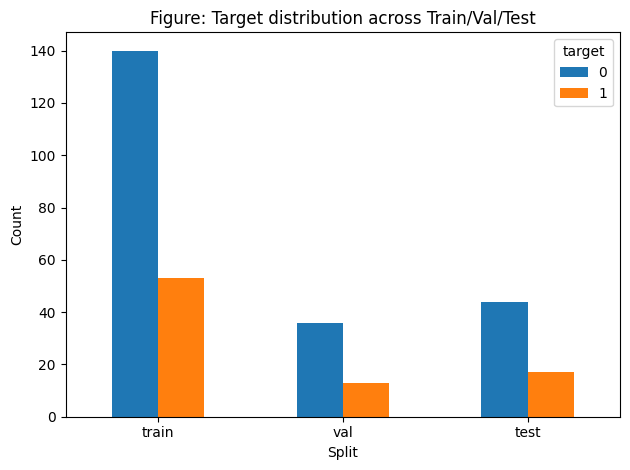

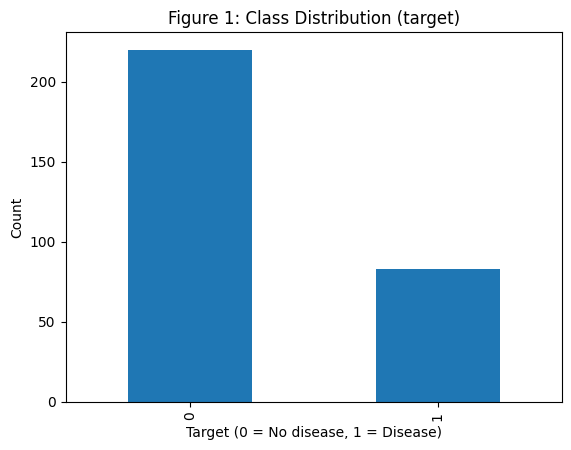

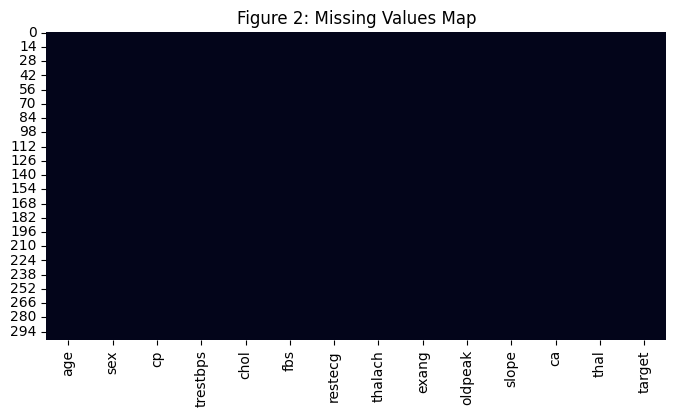

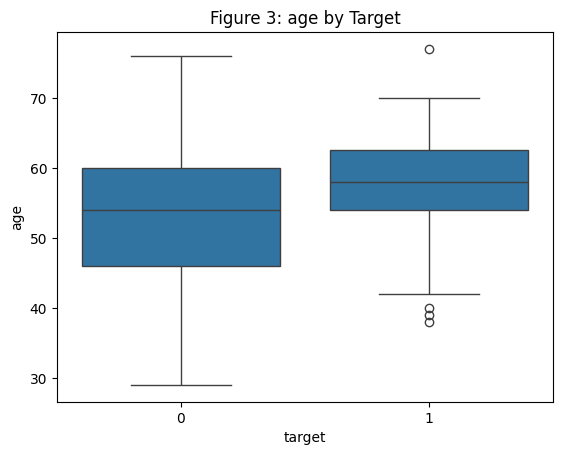

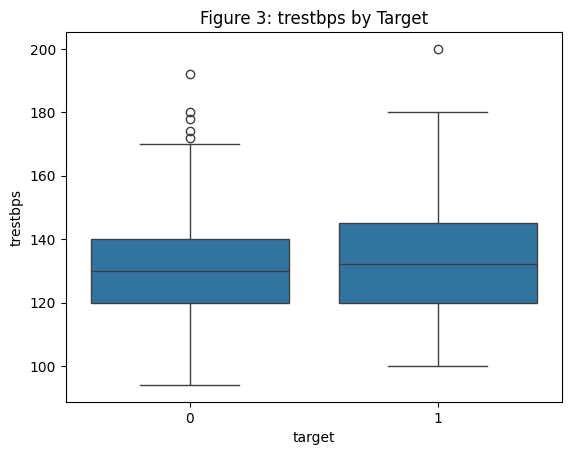

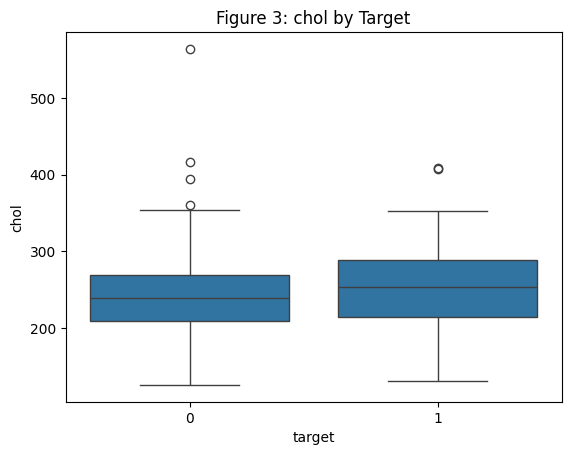

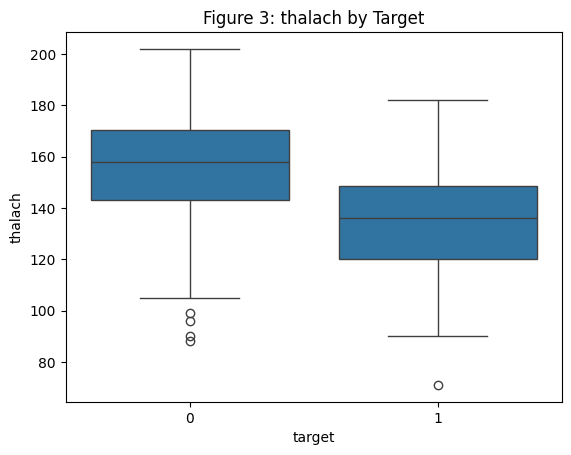

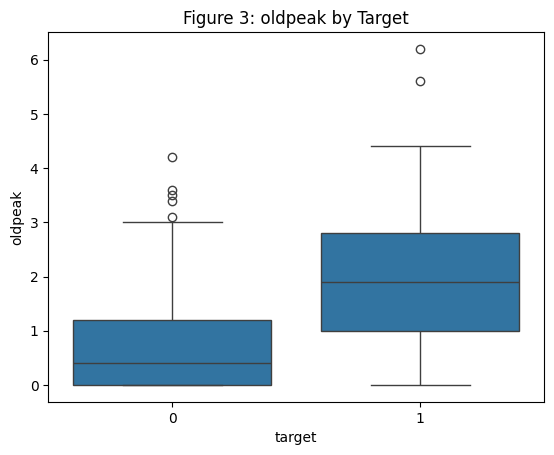

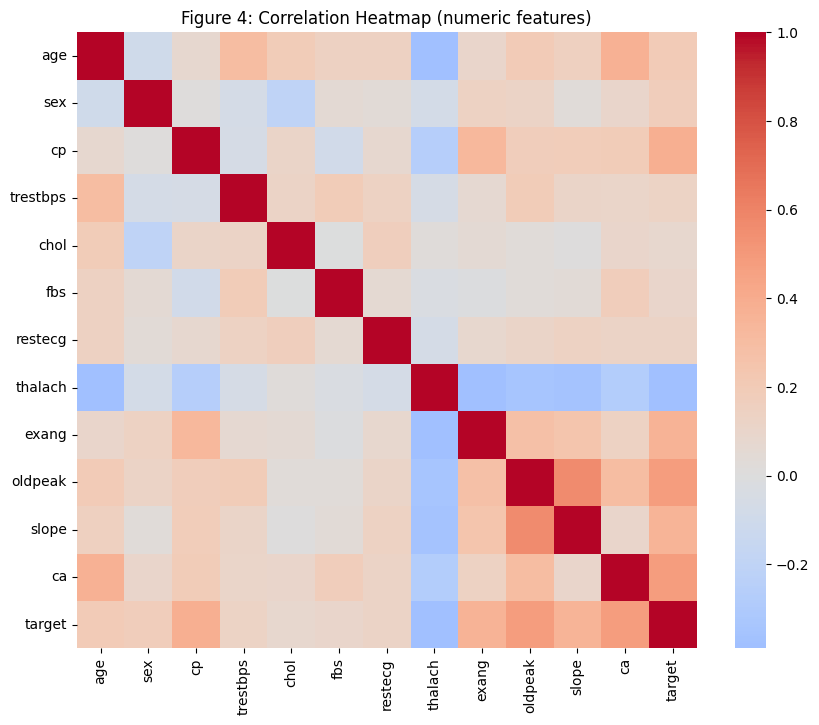

In [ ]:
print(f'Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}')
show_target_counts(y_train, y_val, y_test)
eda_plots(df)

# **ML candidates**

## Classical Machine Learning Models

We first train classical machine learning models as baselines.
These models are well-suited for structured/tabular data and provide strong reference performance.


In [ ]:
def train_ml(name, model, grid):
    """Training and tuning a classical ML model with leakage-safe preprocessing + CV.

    Why this exists:
    - We want a fair comparison between models.
    - Hyperparameter tuning must happen using ONLY training data + cross-validation.
    - Preprocessing must be inside the pipeline so each CV fold fits transforms on that fold's train split.

    Protocol:
    1) Building Pipeline: preprocess -> classifier
    2) GridSearchCV on TRAIN with ROC-AUC scoring (threshold-free)
    3) Evaluating best estimator on VAL to get VAL AUC
    4) Choosing a decision threshold on VAL (maximize F1)
    5) Returning the tuned model + selected threshold (TEST untouched)

    Returns
    -------
    dict with keys:
        name, model (best estimator), thr (val-selected threshold), val_auc, best_params
    """
    # End-to-end pipeline ensures preprocessing is included inside CV (prevents data leakage)
    pipe = Pipeline([
        ('prep', make_preprocess(X.columns)),
        ('clf', model)
    ])

    # Stratified CV keeps class balance consistent across folds
    cv = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)

    # Optimizing hyperparameters using CV ROC-AUC (threshold-independent)
    gs = GridSearchCV(pipe, grid, scoring='roc_auc', cv=cv, n_jobs=-1)
    gs.fit(X_train, y_train)

    # Best pipeline after CV tuning
    best = gs.best_estimator_

    # Validation probability predictions (positive class = 1)
    val_prob = best.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_prob)

    print(f'\n{name}')
    print(f'Best params: {gs.best_params_}')
    print(f'VAL AUC: {val_auc:.3f}')

    # Choosing a classification threshold using VALIDATION predictions only (do NOT tune on test)
    thr = plot_threshold_sweep(y_val, val_prob, f'Threshold Sweep (VAL) - {name}')
    return {'name': name, 'model': best, 'thr': float(thr), 'val_auc': float(val_auc), 'best_params': gs.best_params_}


Logistic Regression
Best params: {'clf__C': 0.1}
VAL AUC: 0.949


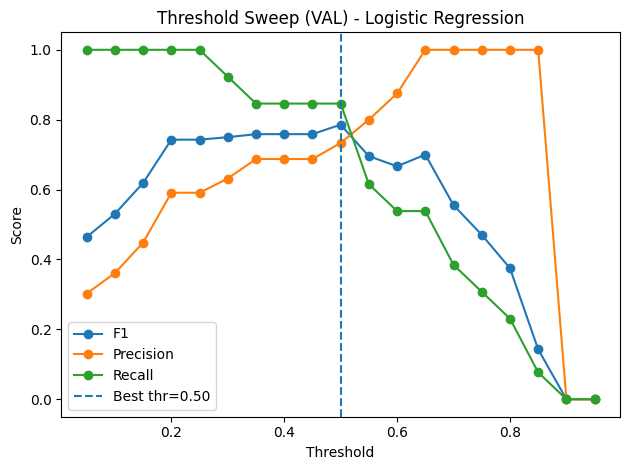

Chosen threshold (max F1 on VAL): 0.50


In [ ]:
# -------------------- Classical ML model candidates --------------------
# We are trying a few standard baselines:
# 1) Logistic Regression: strong, interpretable baseline for tabular clinical data
# 2) Random Forest: non-linear model that can capture interactions
# 3) XGBoost: gradient-boosted trees, often strong on tabular tasks
#
# NOTE: class_weight='balanced' is used where applicable to reduce bias when classes are uneven.

ml_results = []

ml_results.append(train_ml(
    'Logistic Regression',
    LogisticRegression(
        max_iter=5000,              # higher iter count -> reduces convergence warnings
        class_weight='balanced',    # handle class imbalance by reweighting loss
        random_state=RANDOM_STATE
    ),
    {'clf__C': [0.1, 1, 10]}        # inverse regularization strength
))


Random Forest
Best params: {'clf__max_depth': None, 'clf__n_estimators': 500}
VAL AUC: 0.924


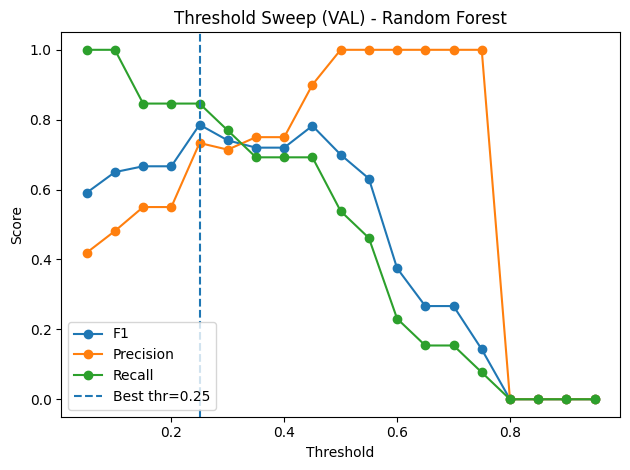

Chosen threshold (max F1 on VAL): 0.25


In [ ]:
ml_results.append(train_ml(
    'Random Forest',
    RandomForestClassifier(
        class_weight='balanced',    # reweight classes
        random_state=RANDOM_STATE
    ),
    {
        'clf__n_estimators': [300, 500],  # number of trees (more trees -> lower variance, slower)
        'clf__max_depth': [None, 6, 10]   # depth controls complexity / overfitting
    }
))



XGBoost
Best params: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.05, 'clf__max_depth': 2, 'clf__subsample': 1.0}
VAL AUC: 0.932


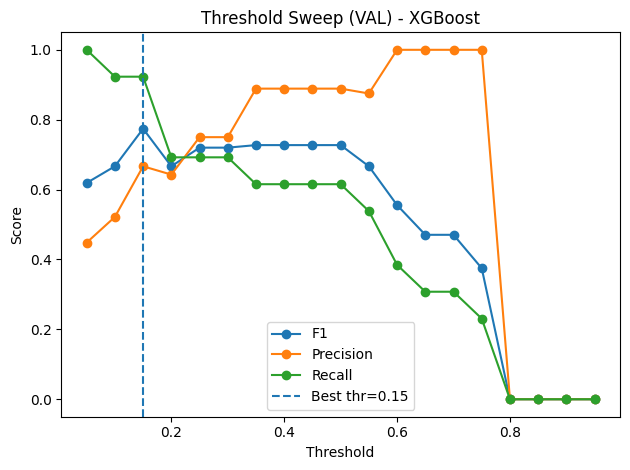

Chosen threshold (max F1 on VAL): 0.15


In [ ]:
ml_results.append(train_ml(
    'XGBoost',
    XGBClassifier(
        objective='binary:logistic',  # binary classification with logistic loss
        eval_metric='auc',            # evaluating with AUC during training
        random_state=RANDOM_STATE,
        n_jobs=-1                     # using all CPU cores
    ),
    {
        'clf__max_depth': [2, 3, 4],          # tree depth
        'clf__learning_rate': [0.01, 0.05, 0.1],
        'clf__subsample': [0.8, 1.0],         # row subsampling (regularization)
        'clf__colsample_bytree': [0.8, 1.0]   # column subsampling (regularization)
    }
))


In [ ]:
ml_results = sorted(ml_results, key=lambda d: d['val_auc'], reverse=True)

In [ ]:
# Selecting the best ML model based on validation ROC-AUC (test set remains untouched)
best_ml = ml_results[0]
print(f'\nBEST ML (by VAL AUC): {best_ml["name"]}  val_auc={best_ml["val_auc"]:.3f}')


BEST ML (by VAL AUC): Logistic Regression  val_auc=0.949


# **DL candidates**

## Deep Learning Model (PyTorch)

We implement a Multi-Layer Perceptron (MLP) using PyTorch.
The neural network is trained using mini-batch gradient descent and evaluated in the same framework as the ML models.


In [ ]:
# Fitting preprocessing ONLY on training data to avoid leakage; reuse the same transform for val/test
prep_dl = make_preprocess(X.columns)
X_tr_p = to_dense(prep_dl.fit_transform(X_train))
X_val_p = to_dense(prep_dl.transform(X_val))
X_test_p = to_dense(prep_dl.transform(X_test))

In [ ]:
# -------------------- Converting preprocessed features to PyTorch tensors --------------------
# PyTorch models expect float32 tensors.
# IMPORTANT: We reuse the *same* preprocessing fitted on TRAIN to transform VAL/TEST.
# That avoids leakage and ensures consistent feature space.

X_tr_t = torch.tensor(X_tr_p, dtype=torch.float32)
y_tr_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_t = torch.tensor(X_val_p, dtype=torch.float32)
X_test_t = torch.tensor(X_test_p, dtype=torch.float32)

In [ ]:
# Mini-batch training for the neural network (shuffle improves SGD behavior)
train_loader = DataLoader(TensorDataset(X_tr_t, y_tr_t), batch_size=32, shuffle=True, drop_last=True)

In [ ]:
# -------------------- Deep Learning baseline: small MLP --------------------
# This is a simple feed-forward network for tabular binary classification.
# Output is a single logit (unnormalized score). We are applying sigmoid later to get probabilities.
class MLP_small(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
       # Forwarding pass returns logits (shape: [batch, 1])
        return self.net(x)

In [ ]:
# -------------------- Deep Learning candidate: MLP + BatchNorm + Dropout --------------------
# Motivation:
# - BatchNorm stabilizes training and helps gradients flow.
# - Dropout regularizes and reduces overfitting (important with small tabular datasets).
class MLP_BN(nn.Module):
    """Higher-capacity MLP with BatchNorm + Dropout.

    Architecture: d -> 128 -> 64 -> 1 (with BN/ReLU/Dropout)
    - More parameters than MLP_small -> can model more complex interactions.
    - Needs regularization to avoid overfitting.
    """
    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
    def forward(self, x):

        return self.net(x)

In [ ]:


def train_dl_candidate(name, model_class, lr=1e-3, epochs=150):
    """Training one neural-network candidate and select the best checkpoint on validation AUC.

    Why this exists:
    - We want a fair DL baseline that follows the same protocol as ML models:
        TRAIN for fitting, VALIDATION for model selection, TEST only once at the end.
    - Neural nets can overfit quickly; we keep the *best epoch* based on validation ROC-AUC.

    Parameters
    ----------
    name : str
        Label used in prints/plots.
    model_class : nn.Module class
        Network constructor (expects input dimension `d`).
    lr : float
        Learning rate for Adam optimizer.
    epochs : int
        Number of epochs to train.

    Returns
    -------
    dict
        Contains best validation AUC, selected threshold (from VAL), and the best model state_dict.
    """
    # Reproducibility: fixing random seeds (note: full determinism in PyTorch can require extra flags)
    torch.manual_seed(RANDOM_STATE)
    np.random.seed(RANDOM_STATE)

     # Building model using the number of input features after preprocessing
    model = model_class(X_tr_t.shape[1])

    # Adam is a strong default optimizer for small/medium tabular nets
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    # BCEWithLogitsLoss is numerically stable for binary classification (combines sigmoid + BCE internally)
    loss_fn = nn.BCEWithLogitsLoss()

    # Tracking the best checkpoint according to VALIDATION AUC
    best_auc = -1.0
    best_state = None
    best_val_prob = None

    train_losses = []
    val_aucs = []

    for epoch in range(epochs):
        # -------------------- TRAIN (one epoch) --------------------
        # train() enables dropout and updates batchnorm running stats
        model.train()
        total = 0.0
        for xb, yb in train_loader:
          # 1) reset gradients
            opt.zero_grad()

            # 2) forward pass -> logits
            logits = model(xb)

            # 3) compute loss (BCE on logits)
            loss = loss_fn(logits, yb)

            # 4) backprop + optimizer step
            loss.backward()
            opt.step()

            # accumulate loss (weighted by batch size)
            total += loss.item() * xb.size(0)

        # average training loss for this epoch
        train_losses.append(float(total / len(X_tr_t)))

        # -------------------- VALIDATION evaluation --------------------
        # eval() disables dropout and uses batchnorm running statistics
        model.eval()
        with torch.no_grad():
            # Model outputs logits -> apply sigmoid to obtain probabilities in [0, 1]
            val_prob = torch.sigmoid(model(X_val_t)).numpy().ravel()

         # Validation ROC-AUC is threshold-free and good for checkpoint selection
        auc = roc_auc_score(y_val, val_prob)
        val_aucs.append(float(auc))

        # Keeping the best checkpoint by VALIDATION ROC-AUC (not by training loss)
        if auc > best_auc:
            best_auc = float(auc)
            # Cloning to CPU to store a safe copy of the parameters at the best epoch
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            best_val_prob = val_prob.copy()

    print(f'\n{name}')
    print(f'lr={lr} | best VAL AUC={best_auc:.3f}')

    # -------------------- Training diagnostics plots --------------------
    plt.figure()
    plt.plot(train_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.title(f'Figure: {name} Train Loss (lr={lr})')
    plt.show()

    plt.figure()
    plt.plot(val_aucs)
    plt.xlabel('Epoch')
    plt.ylabel('VAL ROC-AUC')
    plt.title(f'Figure: {name} VAL AUC across epochs (lr={lr})')
    plt.show()

    # Selecting threshold on validation predictions ONLY; reuse this threshold later for test evaluation
    thr = plot_threshold_sweep(y_val, best_val_prob, f'Threshold Sweep (VAL) - {name}')
    return {'name': name, 'class': model_class, 'lr': float(lr), 'val_auc': float(best_auc), 'thr': float(thr), 'state': best_state}


## Hyperparameter Exploration

To study the effect of hyperparameters, we explicitly vary the learning rate of the neural network.
Validation performance is used to compare different configurations, as required by the assignment.



MLP_BN
lr=0.0001 | best VAL AUC=0.962


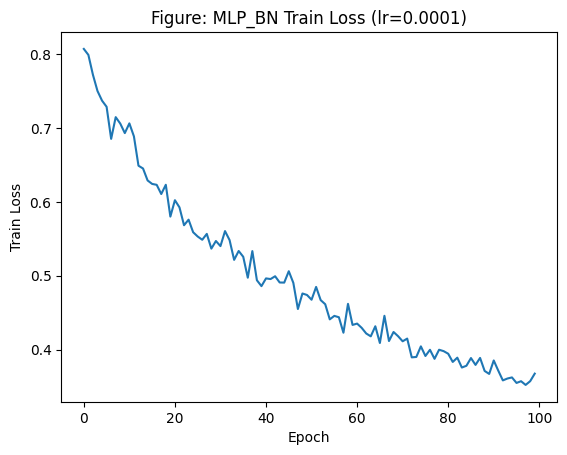

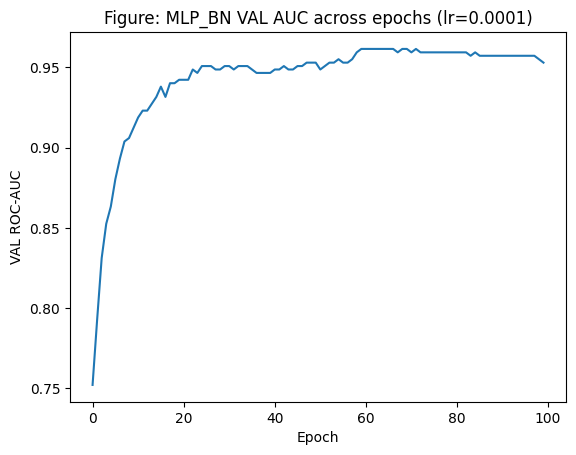

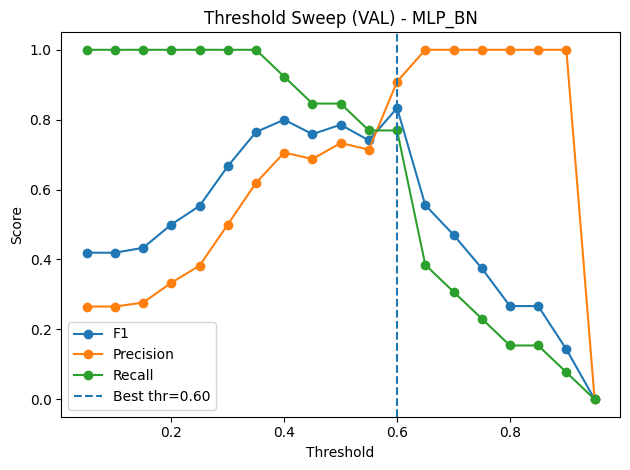

Chosen threshold (max F1 on VAL): 0.60

MLP_BN
lr=0.001 | best VAL AUC=0.974


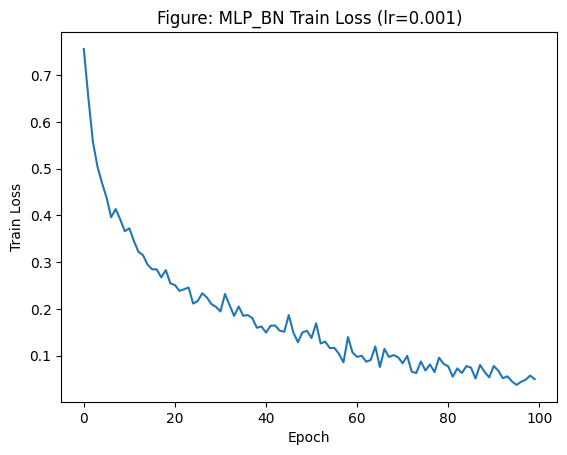

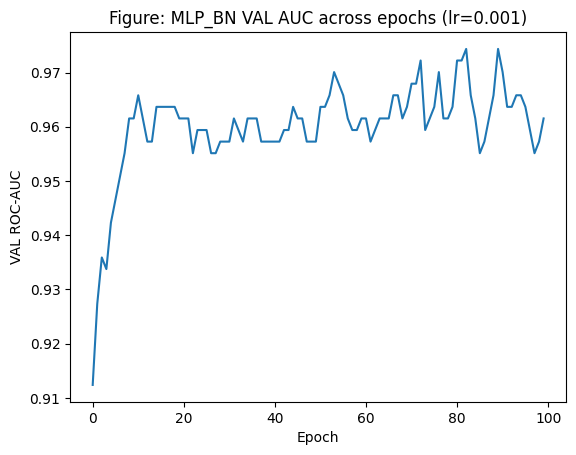

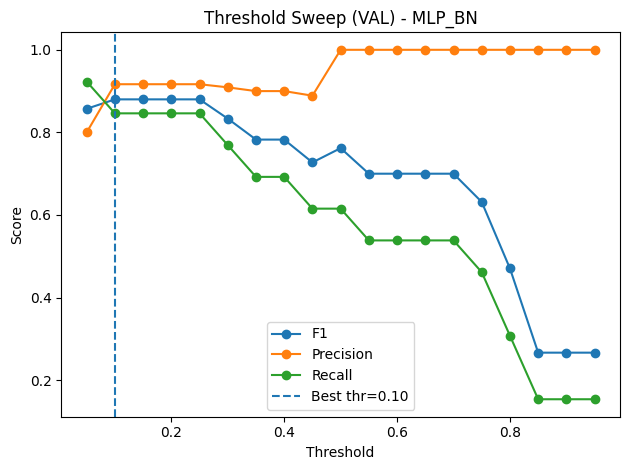

Chosen threshold (max F1 on VAL): 0.10

MLP_BN
lr=0.01 | best VAL AUC=0.981


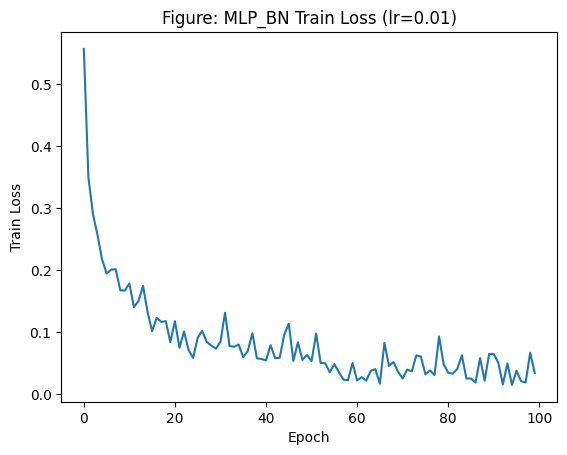

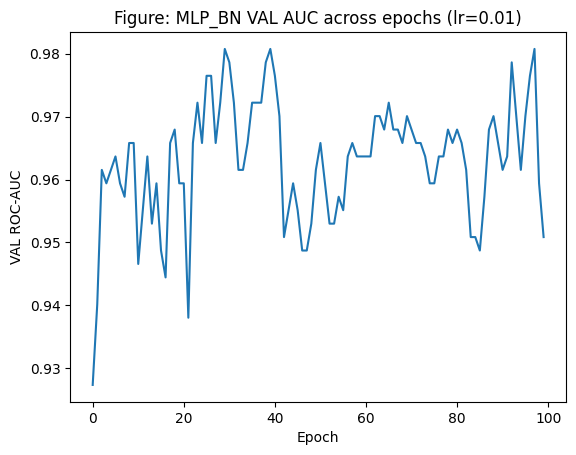

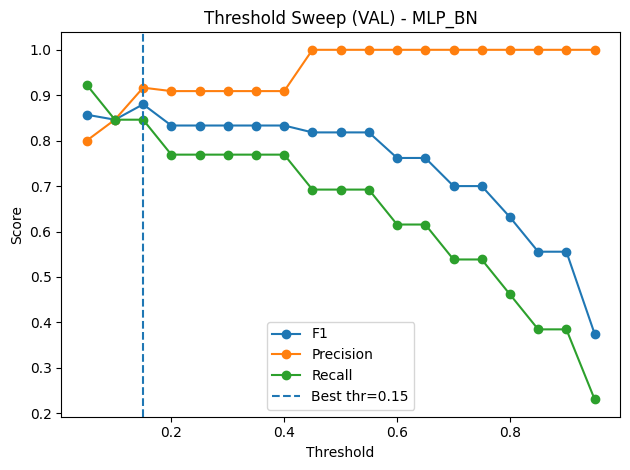

Chosen threshold (max F1 on VAL): 0.15

DL learning rate comparison (MLP_BN):
lr=0.0001 -> VAL AUC=0.962
lr=0.001 -> VAL AUC=0.974
lr=0.01 -> VAL AUC=0.981


In [ ]:
# -------------------- DL learning-rate sweep (sanity check) --------------------
# Learning rate can make or break NN training.
# We do a small sweep to see which LR gives the best validation AUC for the MLP_BN model.
lr_list = [1e-4, 1e-3, 1e-2]
dl_lr_results = []

for lr in lr_list:
    res = train_dl_candidate('MLP_BN', MLP_BN, lr=lr, epochs=100)
    dl_lr_results.append({'lr': float(lr), 'val_auc': float(res['val_auc'])})

print(f'\nDL learning rate comparison (MLP_BN):')
for r in dl_lr_results:
    print(f'lr={r["lr"]} -> VAL AUC={r["val_auc"]:.3f}')

## Evaluation Metrics

We evaluate model performance using:
- ROC-AUC (primary metric)
- Accuracy
- Precision
- Recall
- F1-score

Threshold selection is performed on validation data only.



MLP_small
lr=0.001 | best VAL AUC=0.966


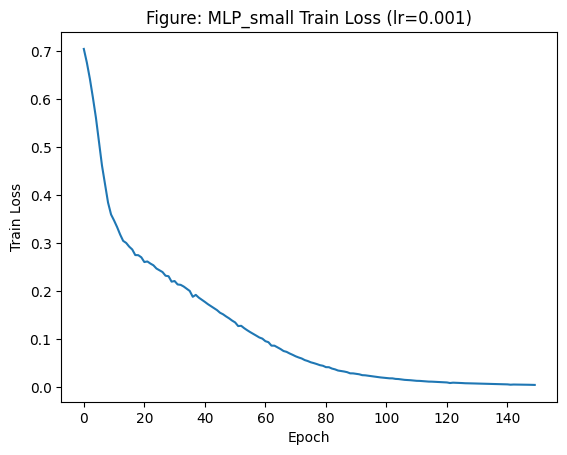

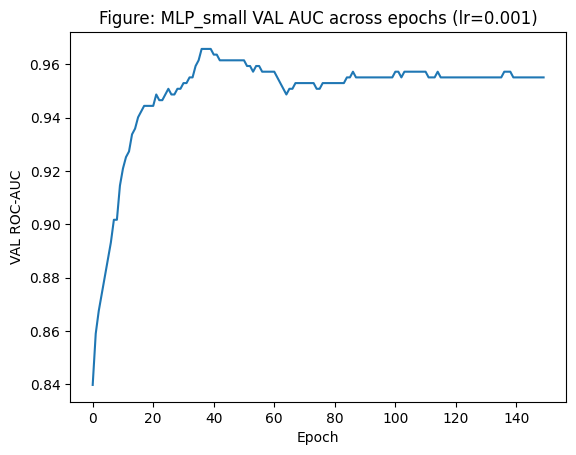

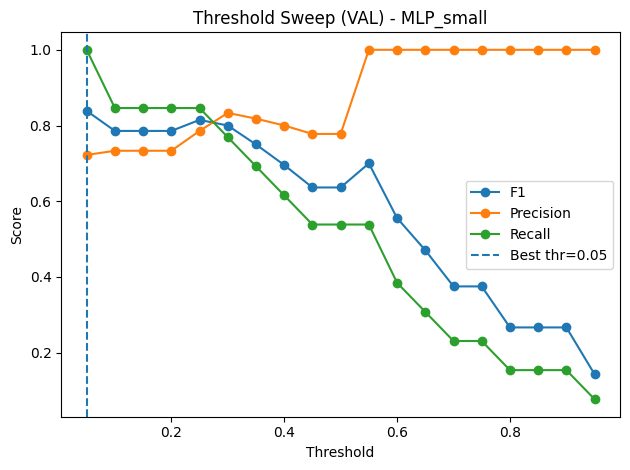

Chosen threshold (max F1 on VAL): 0.05

MLP_BN
lr=0.001 | best VAL AUC=0.983


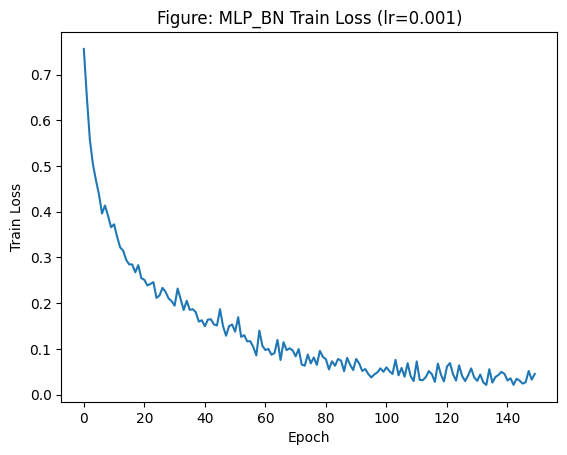

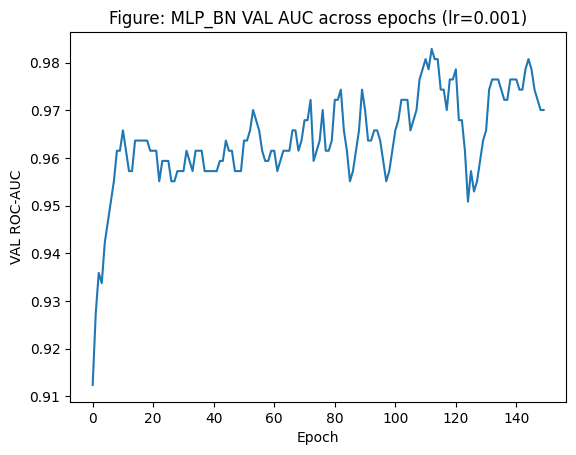

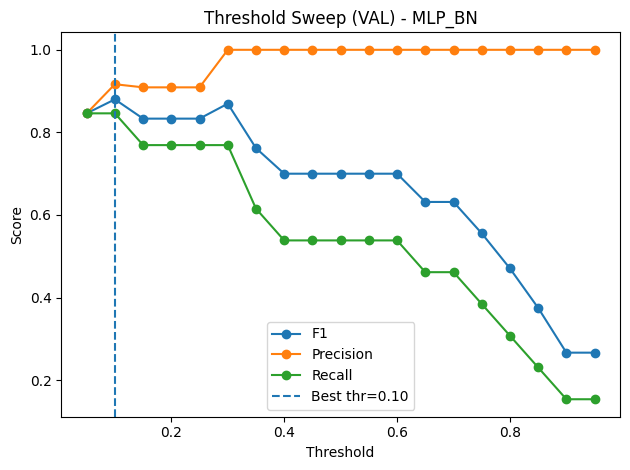

Chosen threshold (max F1 on VAL): 0.10


In [ ]:
# -------------------- Training DL candidates under the same protocol --------------------
# We are comparing two architectures:
# - MLP_small: low-capacity baseline
# - MLP_BN: higher-capacity + regularization (BatchNorm + Dropout)
#
# IMPORTANT: We compare using VALIDATION ROC-AUC and pick the best threshold on VALIDATION.
dl_results = []
dl_results.append(train_dl_candidate('MLP_small', MLP_small, lr=1e-3, epochs=150))
dl_results.append(train_dl_candidate('MLP_BN', MLP_BN, lr=1e-3, epochs=150))

In [ ]:
# Selecting the best DL model based on validation ROC-AUC (test set remains untouched)
dl_results = sorted(dl_results, key=lambda d: d['val_auc'], reverse=True)
best_dl = dl_results[0]
print(f'\nBEST DL (by VAL AUC): {best_dl["name"]}  val_auc={best_dl["val_auc"]:.3f}')


BEST DL (by VAL AUC): MLP_BN  val_auc=0.983


In [ ]:
# Rebuilding the best NN and load the best validation checkpoint for final test evaluation
final_dl = best_dl['class'](X_tr_t.shape[1])
final_dl.load_state_dict(best_dl['state'])
final_dl.eval()

MLP_BN(
  (net): Sequential(
    (0): Linear(in_features=31, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

# **Final Test Evaluation**



After fixing all model choices and thresholds on the validation set,
we evaluate the selected models once on the held-out test set to obtain an unbiased performance estimate.


In [ ]:
# Final TEST evaluation: applying the validation-selected threshold (no re-tuning on test)
ml_test_prob = best_ml['model'].predict_proba(X_test)[:, 1]
ml_test_m = eval_metrics(y_test, ml_test_prob, best_ml['thr'])
print_metrics(f'BEST ML ({best_ml["name"]}) TEST', ml_test_m)


[BEST ML (Logistic Regression) TEST]
Accuracy : 0.869
Precision: 0.846
Recall   : 0.647
F1       : 0.733
ROC-AUC  : 0.943


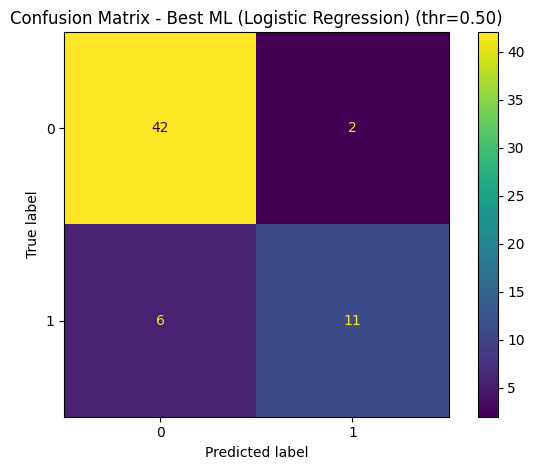

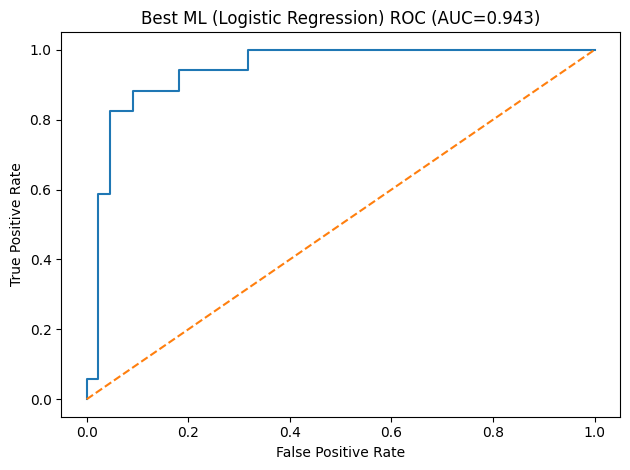

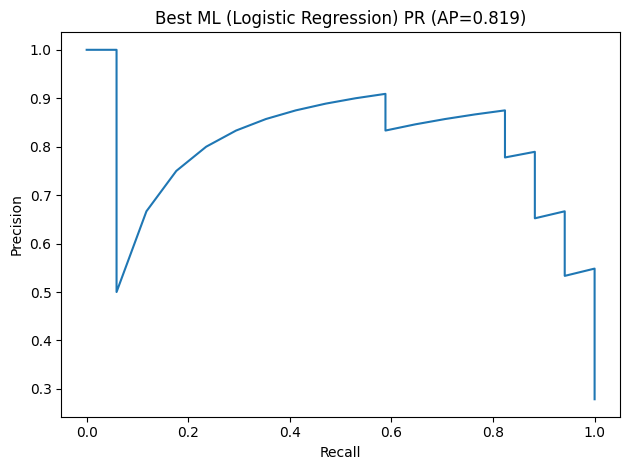

In [ ]:
plot_cm(y_test, ml_test_prob, best_ml['thr'], f'Confusion Matrix - Best ML ({best_ml["name"]})')
plot_roc_pr(y_test, ml_test_prob, f'Best ML ({best_ml["name"]})')

In [ ]:
# Final TEST evaluation: logits -> sigmoid probabilities; apply the same validation-selected threshold
with torch.no_grad():
    dl_test_prob = torch.sigmoid(final_dl(X_test_t)).numpy().ravel()
dl_test_m = eval_metrics(y_test, dl_test_prob, best_dl['thr'])
print_metrics(f'BEST DL ({best_dl["name"]}) TEST', dl_test_m)


[BEST DL (MLP_BN) TEST]
Accuracy : 0.754
Precision: 0.600
Recall   : 0.353
F1       : 0.444
ROC-AUC  : 0.865


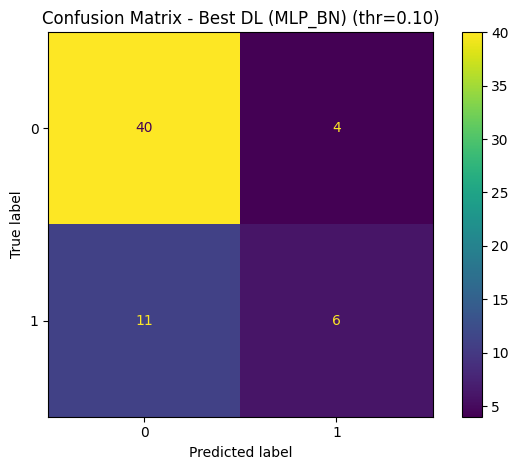

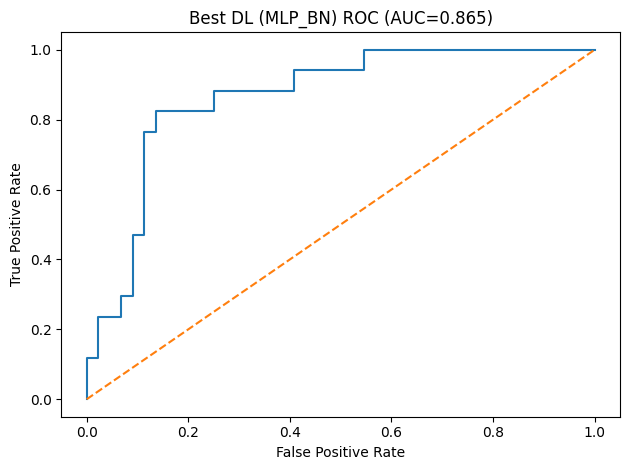

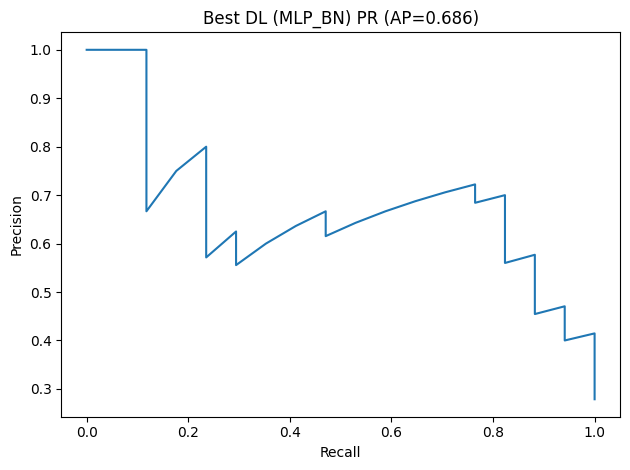

In [ ]:
plot_cm(y_test, dl_test_prob, best_dl['thr'], f'Confusion Matrix - Best DL ({best_dl["name"]})')
plot_roc_pr(y_test, dl_test_prob, f'Best DL ({best_dl["name"]})')

## Outputs

This notebook produces:
- Test-set performance metrics for ML and DL models
- ROC curves and confusion matrices
- A comparison table between the best ML and best DL approaches


In [ ]:
# Report final comparison on TEST set only (after all choices were fixed on validation)
print(f'\nFINAL VERDICT (TEST only):')
print(f'Best ML: {best_ml["name"]} | AUC={ml_test_m["auc"]:.3f} | F1={ml_test_m["f1"]:.3f}')
print(f'Best DL: {best_dl["name"]} | AUC={dl_test_m["auc"]:.3f} | F1={dl_test_m["f1"]:.3f}')


FINAL VERDICT (TEST only):
Best ML: Logistic Regression | AUC=0.943 | F1=0.733
Best DL: MLP_BN | AUC=0.865 | F1=0.444


In [ ]:
comp = pd.DataFrame([
    {'Model': f'Best ML: {best_ml["name"]}', 'ROC_AUC': ml_test_m['auc'], 'F1': ml_test_m['f1']},
    {'Model': f'Best DL: {best_dl["name"]}', 'ROC_AUC': dl_test_m['auc'], 'F1': dl_test_m['f1']}
])

In [ ]:
print(f'\nComparison table (TEST only):\n{comp}')


Comparison table (TEST only):
                          Model   ROC_AUC        F1
0  Best ML: Logistic Regression  0.942513  0.733333
1               Best DL: MLP_BN  0.864973  0.444444


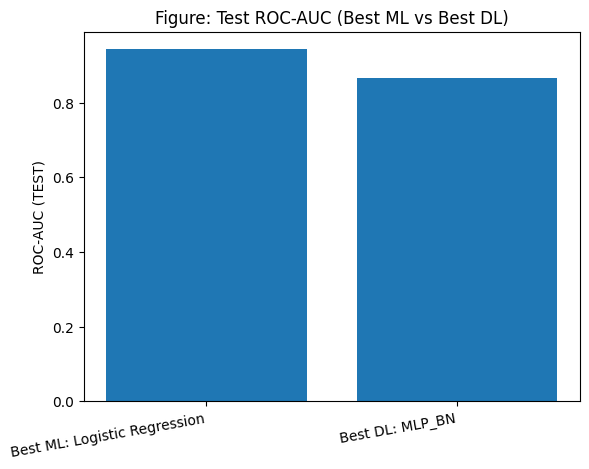

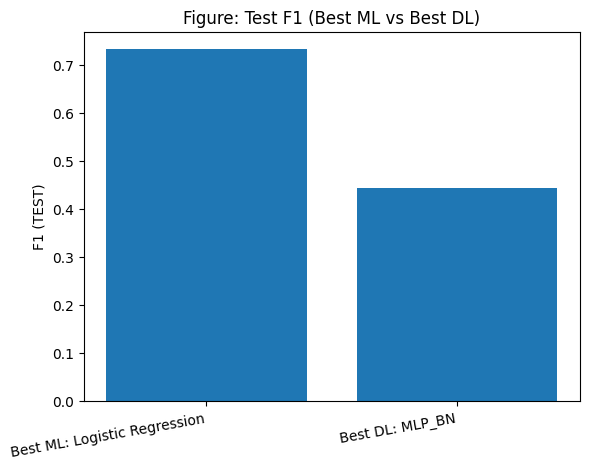

In [ ]:
plt.figure()
plt.bar(comp['Model'], comp['ROC_AUC'])
plt.xticks(rotation=10, ha='right')
plt.ylabel('ROC-AUC (TEST)')
plt.title('Figure: Test ROC-AUC (Best ML vs Best DL)')
plt.show()

plt.figure()
plt.bar(comp['Model'], comp['F1'])
plt.xticks(rotation=10, ha='right')
plt.ylabel('F1 (TEST)')
plt.title('Figure: Test F1 (Best ML vs Best DL)')
plt.show()

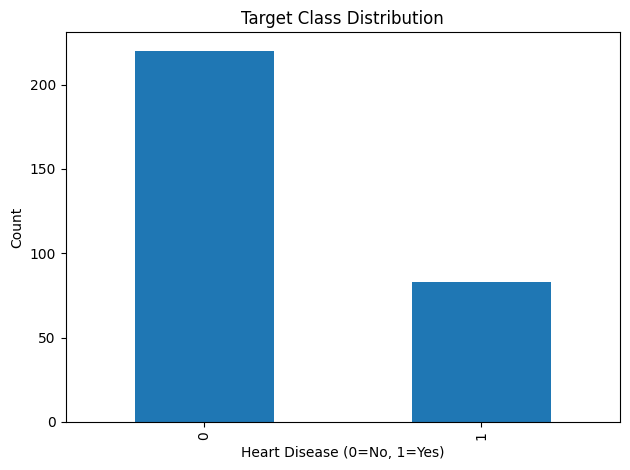

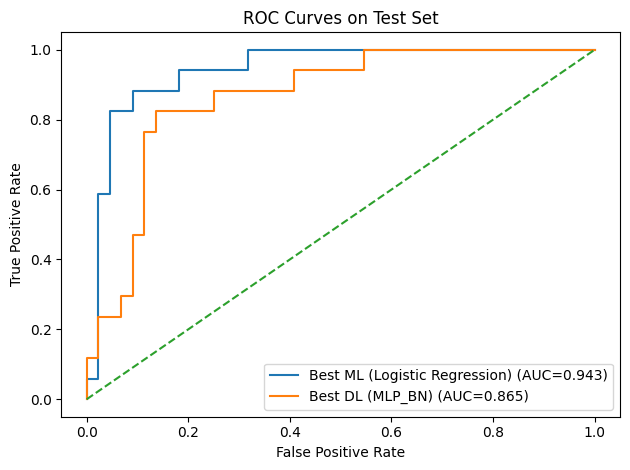

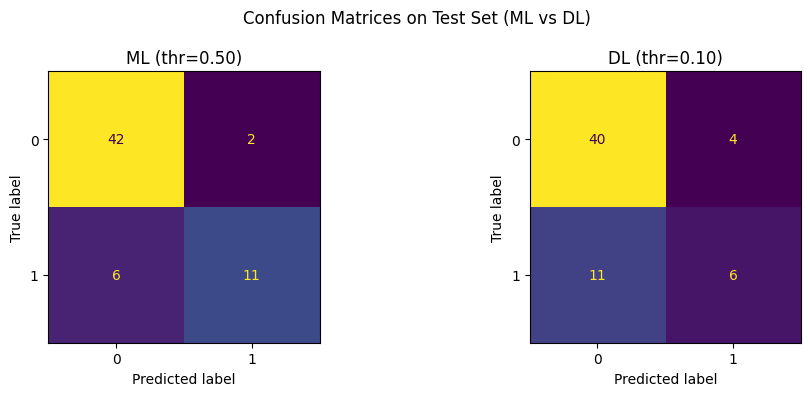

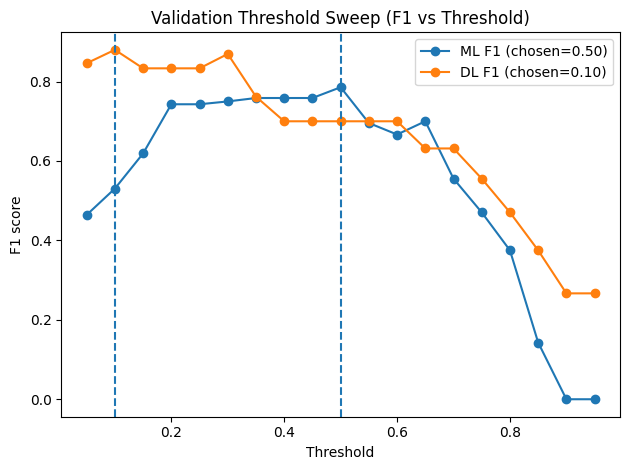

In [ ]:
import os

os.makedirs("figures", exist_ok=True)

# ---------- Fig 1: Class distribution ----------
y.value_counts().plot(kind="bar")
plt.title("Target Class Distribution")
plt.xlabel("Heart Disease (0=No, 1=Yes)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("figures/fig1_class_dist.png", dpi=200, bbox_inches="tight")
plt.show()

# ---------- Compute probabilities for BEST ML and BEST DL on TEST ----------
# Best ML
ml_test_prob = best_ml["model"].predict_proba(X_test)[:, 1]

# Best DL
with torch.no_grad():
    dl_test_prob = torch.sigmoid(final_dl(X_test_t)).numpy().ravel()

# ---------- Fig 2: ROC compare (TEST) ----------
plot_roc_compare(
    y_test,
    ml_test_prob,
    dl_test_prob,
    label_ml=f'Best ML ({best_ml["name"]})',
    label_dl=f'Best DL ({best_dl["name"]})',
    title="ROC Curves on Test Set",
    save_path="figures/fig2_roc_test_ml_vs_dl.png"
)

# ---------- Fig 3: Confusion matrices compare (TEST) ----------
plot_cm_compare(
    y_test,
    ml_test_prob, best_ml["thr"],
    dl_test_prob, best_dl["thr"],
    title="Confusion Matrices on Test Set (ML vs DL)",
    save_path="figures/fig3_cm_test_ml_vs_dl.png"
)

# ---------- Fig 4: Threshold sweep compare (VAL) ----------
ml_val_prob = best_ml["model"].predict_proba(X_val)[:, 1]
with torch.no_grad():
    dl_val_prob = torch.sigmoid(final_dl(X_val_t)).numpy().ravel()

plot_threshold_sweep_compare(
    y_val,
    ml_val_prob, best_ml["thr"],
    dl_val_prob, best_dl["thr"],
    title="Validation Threshold Sweep (F1 vs Threshold)",
    save_path="figures/fig4_thr_sweep_val_ml_vs_dl.png"
)

